# Evaluate bulk properties

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import sys
sys.path.append('../../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-24 20:34:47.864194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 20:34:47.877797: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 20:34:47.881865: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# We need one place to save all the experiment relevant info.  
common_config= {'simulation_names':['DG','P2L'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    #'window_size':3, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated_nondim',
                                          'vphp_rotated_nondim'],
                    
                    'coeff_channels'  : [], 

                    'extra_channels'   : [  'uphp_rotated',
                                            'vphp_rotated', 
                                            'mag_nabla_h_widened',
                                            'mag_nabla_u_widened',
                                            'filter_scale'],

                    'use_coeff_channels': False,
                    'single_layer_mask': True,

                    'all_time_range': slice(3600-513, 3600),
                    #'train_time_range': slice(0, 2048),
                    #'test_time_range' : slice(-128, None),
                    'eval_time_range' : slice(-513, None),
                    #'num_train_batches': 128, 
                    #'num_test_batches' : 8, 

                    #'num_inputs': 55, 
                    'network_shape': [48, 48, 2],

                    'ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/main_models/window_all/shape_48_48_2/'
                    
            }

In [3]:
experiment_configs = {'1point':{'window_size':1, 'num_inputs':6, 'exp_ckpt_save_dir': common_config['ckpt_save_dir']+'1point'},
                      '3point':{'window_size':3, 'num_inputs':3*3*6, 'exp_ckpt_save_dir': common_config['ckpt_save_dir']+'3point'},
                      '5point':{'window_size':5, 'num_inputs':5*5*6, 'exp_ckpt_save_dir': common_config['ckpt_save_dir']+'5point'}    
                        }

In [4]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
for key in ['5point']:#experiment_configs.keys():

    print('Starting to load in DT for: ' + key)
    
    experiment_configs[key]['DT'] = datasets.SimulationData(simulation_names=common_config['simulation_names'], 
                         filter_scales=common_config['filter_scales'], 
                         window_size = experiment_configs[key]['window_size'], 
                         time_sel = common_config['all_time_range'],
                         single_layer_mask_flag=common_config['single_layer_mask']
                         )

    print('Opening up eval sys: ' + key)
    experiment_configs[key]['eval_sys'] = evaluation.EvalSystem(simulation_data=experiment_configs[key]['DT'],
                                             input_channels=common_config['input_channels'],
                                             output_channels=common_config['output_channels'], 
                                             coeff_channels=common_config['coeff_channels'], 
                                             extra_channels=common_config['extra_channels'],
                                             use_norm_factors=True,
                                             eval_time_slice= common_config['eval_time_range'], 
                                             num_inputs=experiment_configs[key]['num_inputs'], 
                                             shape=common_config['network_shape'], 
                                             ckpt_dir=experiment_configs[key]['exp_ckpt_save_dir'],
                                             use_coeff_channels=common_config['use_coeff_channels'])

    print('Reading model and predicting: ' + key)
    
    experiment_configs[key]['eval_sys'].read_ann_regression_model()
    experiment_configs[key]['eval_sys'].read_eval_data()
    experiment_configs[key]['eval_sys'].predict()
    experiment_configs[key]['eval_sys'].dimensionalize()

Starting to load in DT for: 5point
Opening up eval sys: 5point
Reading model and predicting: 5point


In [5]:
# Make predictions using GM and VGM models 

for key in ['5point']:#experiment_configs.keys(): 
    experiment_configs[key]['eval_sys'].add_gradient_model_variables()
    experiment_configs[key]['eval_sys'].add_gent_mcwilliams_variables()

In [6]:
%%time
for key in ['5point']: 
    experiment_configs[key]['eval_sys'].coarsen_time_ML_data()
    
    #experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='time', dims=['Time'])
    #experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='time', dims=['Time'])
    print('here')
    #experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)
    #experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)

    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='layerwise', dims=['Time','xh','yh'], use_default_subregions=True)
    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='layerwise', dims=['Time','xh','yh'], use_default_subregions=True)

here
CPU times: user 41min 51s, sys: 16min 9s, total: 58min 1s
Wall time: 8min 19s


In [9]:
bulk_skill_metrics = xr.open_dataset('bulk_skill_metrics.nc')

data_keys = list(common_config['simulation_names'])
model_keys = ['5point']
filter_scales = common_config['filter_scales']
coarsen_time_scales = experiment_configs[key]['eval_sys'].coarsen_times
coarsen_time_scales.insert(0, '0')


R2_data = np.full((len(data_keys), len(filter_scales), len(coarsen_time_scales), len(model_keys)), np.nan)
corr_data = np.full((len(data_keys), len(filter_scales), len(coarsen_time_scales), len(model_keys)), np.nan)

for i, data_key in enumerate(data_keys):
    for l, model_key in enumerate(model_keys):
        for j, scale_key in enumerate(filter_scales):
            for k, coarsen_key in enumerate(coarsen_time_scales):
        
                if coarsen_key == '0': 
                    if model_key == 'grad_model':
                        R2_data[i, j, k, l] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_R2_grad_model_all.values +
                                        experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_R2_grad_model_all.values )
            
                        corr_data[i, j, k, l] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_corr_grad_model_all.values +
                                        experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_corr_grad_model_all.values )
                    elif model_key == 'gent_mcwilliams': # we only use downgradient prediction for this case.
                        R2_data[i, j, k, l] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_R2_gent_mcwilliams_all.values)
            
                        corr_data[i, j, k, l] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_corr_gent_mcwilliams_all.values)
                    else:
                        R2_data[i, j, k, l] = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_R2_all.values +
                                        experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_R2_all.values )
            
                        corr_data[i, j, k, l] = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_corr_all.values +
                                        experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_corr_all.values )

                else: 
                    if model_key == 'grad_model':
                        R2_data[i, j, k, l] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_R2_grad_model_all.values +
                                        experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].vphp_rotated_R2_grad_model_all.values )
            
                        corr_data[i, j, k, l] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_corr_grad_model_all.values +
                                        experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].vphp_rotated_corr_grad_model_all.values )
                    elif model_key == 'gent_mcwilliams': # we only use downgradient prediction for this case.
                        R2_data[i, j, k, l] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_R2_gent_mcwilliams_all.values)
            
                        corr_data[i, j, k, l] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_corr_gent_mcwilliams_all.values)
                    else:
                        R2_data[i, j, k, l] = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_R2_all.values +
                                        experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].vphp_rotated_R2_all.values )
            
                        corr_data[i, j, k, l] = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_corr_all.values +
                                        experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].vphp_rotated_corr_all.values )


bulk_skill_metrics_appends = xr.Dataset()

bulk_skill_metrics_appends['R2'] = xr.DataArray(R2_data, coords={'data_set':data_keys,
                                                          'filter_scales': list(map(int, filter_scales)),
                                                         'coarsen_time': list(map(int, coarsen_time_scales)), 
                                                          'model': model_keys})

bulk_skill_metrics_appends['corr'] = xr.DataArray(corr_data, coords={'data_set':data_keys,
                                                          'filter_scales': list(map(int, filter_scales)),
                                                         'coarsen_time': list(map(int, coarsen_time_scales)), 
                                                          'model': model_keys})

In [10]:
bulk_skill_metrics_appends

<xarray.Dataset> Size: 760B
Dimensions:        (data_set: 2, filter_scales: 4, coarsen_time: 5, model: 1)
Coordinates:
  * data_set       (data_set) <U3 24B 'DG' 'P2L'
  * filter_scales  (filter_scales) int64 32B 50 100 200 400
  * coarsen_time   (coarsen_time) int64 40B 0 16 64 128 256
  * model          (model) <U6 24B '5point'
Data variables:
    R2             (data_set, filter_scales, coarsen_time, model) float64 320B ...
    corr           (data_set, filter_scales, coarsen_time, model) float64 320B ...

In [11]:
bulk_skill_metrics = xr.concat([bulk_skill_metrics, bulk_skill_metrics_appends], dim='model')

In [13]:
bulk_skill_metrics.to_netcdf('bulk_skill_metrics.nc')

In [12]:
data_keys = list(common_config['simulation_names'])
model_keys = ['5point']
filter_scales = common_config['filter_scales']
coarsen_time_scales = experiment_configs['5point']['eval_sys'].coarsen_times.copy()
coarsen_time_scales.insert(0, '0')
direction = ['uphp','vphp']
levels = [0,1]


R2_data = np.full((len(data_keys), len(filter_scales), len(coarsen_time_scales), len(model_keys), len(levels), len(direction)), np.nan)
corr_data = np.full((len(data_keys), len(filter_scales), len(coarsen_time_scales), len(model_keys), len(levels), len(direction)), np.nan)

for i, data_key in enumerate(data_keys):
    for l, model_key in enumerate(model_keys):
        for j, scale_key in enumerate(filter_scales):
            for k, coarsen_key in enumerate(coarsen_time_scales):
                for m, lev_key in enumerate(levels):
                    for n, dir_key in enumerate(direction):
                        
                    
                        if coarsen_key == '0': 
                            if model_key == 'grad_model':
                                R2_data[i, j, k, l, m, n ] = experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][dir_key+'_rotated_R2_grad_model_layerwise'].isel(zl=lev_key).values 
                                corr_data[i, j, k, l, m, n ] = experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][dir_key+'_rotated_corr_grad_model_layerwise'].isel(zl=lev_key).values 
                            elif model_key == 'gent_mcwilliams': # we only use downgradient prediction for this case.
                                R2_data[i, j, k, l, m, n ] = experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][dir_key+'_rotated_R2_gent_mcwilliams_layerwise'].isel(zl=lev_key).values 
                                corr_data[i, j, k, l, m, n ] = experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][dir_key+'_rotated_corr_gent_mcwilliams_layerwise'].isel(zl=lev_key).values 
                            else:
                                R2_data[i, j, k, l, m, n ] = experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][dir_key+'_rotated_R2_layerwise'].isel(zl=lev_key).values 
                                corr_data[i, j, k, l, m, n ] = experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][dir_key+'_rotated_corr_layerwise'].isel(zl=lev_key).values 
        
                        else: 
                            if model_key == 'grad_model':
                                R2_data[i, j, k, l, m, n ] = experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key][dir_key+'_rotated_R2_grad_model_layerwise'].isel(zl=lev_key).values 
                                corr_data[i, j, k, l, m, n ] = experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key][dir_key+'_rotated_corr_grad_model_layerwise'].isel(zl=lev_key).values 
                            elif model_key == 'gent_mcwilliams': # we only use downgradient prediction for this case.
                                R2_data[i, j, k, l, m, n ] = experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key][dir_key+'_rotated_R2_gent_mcwilliams_layerwise'].isel(zl=lev_key).values 
                                corr_data[i, j, k, l, m, n ] = experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key][dir_key+'_rotated_corr_gent_mcwilliams_layerwise'].isel(zl=lev_key).values 
                            else:
                                R2_data[i, j, k, l, m, n ] = experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key][dir_key+'_rotated_R2_layerwise'].isel(zl=lev_key).values 
                                corr_data[i, j, k, l, m, n ] = experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key][dir_key+'_rotated_corr_layerwise'].isel(zl=lev_key).values 




In [13]:
bulk_skill_metrics_layerwise_appends = xr.Dataset()

bulk_skill_metrics_layerwise_appends['R2'] = xr.DataArray(R2_data, coords={'data_set':data_keys,
                                                          'filter_scales': list(map(int, filter_scales)),
                                                         'coarsen_time': list(map(int, coarsen_time_scales)), 
                                                          'model': model_keys,
                                                         'layer': levels,
                                                         'direction': direction})

bulk_skill_metrics_layerwise_appends['corr'] = xr.DataArray(corr_data, coords={'data_set':data_keys,
                                                          'filter_scales': list(map(int, filter_scales)),
                                                         'coarsen_time': list(map(int, coarsen_time_scales)), 
                                                          'model': model_keys, 
                                                            'layer': levels,
                                                         'direction': direction})

In [16]:
bulk_skill_metrics_layerwise_appends

<xarray.Dataset> Size: 3kB
Dimensions:        (data_set: 2, filter_scales: 4, coarsen_time: 5, model: 1,
                    layer: 2, direction: 2)
Coordinates:
  * data_set       (data_set) <U3 24B 'DG' 'P2L'
  * filter_scales  (filter_scales) int64 32B 50 100 200 400
  * coarsen_time   (coarsen_time) int64 40B 0 16 64 128 256
  * model          (model) <U6 24B '5point'
  * layer          (layer) int64 16B 0 1
  * direction      (direction) <U4 32B 'uphp' 'vphp'
Data variables:
    R2             (data_set, filter_scales, coarsen_time, model, layer, direction) float64 1kB ...
    corr           (data_set, filter_scales, coarsen_time, model, layer, direction) float64 1kB ...

In [19]:
bulk_skill_metrics_layerwise = xr.open_dataset('bulk_skill_metrics_layerwise_with_dir.nc')

In [21]:
bulk_skill_metrics_layerwise = xr.concat([bulk_skill_metrics_layerwise, bulk_skill_metrics_layerwise_appends], dim='model')

In [25]:
bulk_skill_metrics_layerwise

<xarray.Dataset> Size: 13kB
Dimensions:        (data_set: 2, filter_scales: 4, coarsen_time: 5, model: 5,
                    layer: 2, direction: 2)
Coordinates:
  * data_set       (data_set) <U3 24B 'DG' 'P2L'
  * filter_scales  (filter_scales) int64 32B 50 100 200 400
  * coarsen_time   (coarsen_time) int64 40B 0 16 64 128 256
  * model          (model) <U15 300B '1point' '3point' ... '5point'
  * layer          (layer) int64 16B 0 1
  * direction      (direction) <U4 32B 'uphp' 'vphp'
Data variables:
    R2             (data_set, filter_scales, coarsen_time, model, layer, direction) float64 6kB ...
    corr           (data_set, filter_scales, coarsen_time, model, layer, direction) float64 6kB ...

In [26]:
bulk_skill_metrics_layerwise.to_netcdf('bulk_skill_metrics_layerwise_with_dir_all.nc')

In [7]:
data_keys = list(common_config['simulation_names'])
model_keys = ['5point']
filter_scales = common_config['filter_scales']
coarsen_time_scales = experiment_configs[key]['eval_sys'].coarsen_times
coarsen_time_scales.insert(0, '0')
levels = [0,1]


R2_data = np.full((len(data_keys), len(filter_scales), len(coarsen_time_scales), len(model_keys), len(levels)), np.nan)
corr_data = np.full((len(data_keys), len(filter_scales), len(coarsen_time_scales), len(model_keys), len(levels)), np.nan)

In [8]:
for i, data_key in enumerate(data_keys):
    for l, model_key in enumerate(model_keys):
        for j, scale_key in enumerate(filter_scales):
            for k, coarsen_key in enumerate(coarsen_time_scales):
                for m, lev_key in enumerate(levels):
        
                
                    if coarsen_key == '0': 
                        if model_key == 'grad_model':
                            R2_data[i, j, k, l,m] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_R2_grad_model_layerwise.isel(zl=lev_key).values +
                                            experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_R2_grad_model_layerwise.isel(zl=lev_key).values )
                
                            corr_data[i, j, k, l, m] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_corr_grad_model_layerwise.isel(zl=lev_key).values +
                                            experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_corr_grad_model_layerwise.isel(zl=lev_key).values )
                        elif model_key == 'gent_mcwilliams': # we only use downgradient prediction for this case.
                            R2_data[i, j, k, l, m] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_R2_gent_mcwilliams_layerwise.isel(zl=lev_key).values)
                
                            corr_data[i, j, k, l, m] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_corr_gent_mcwilliams_layerwise.isel(zl=lev_key).values)
                        else:
                            R2_data[i, j, k, l, m] = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_R2_layerwise.isel(zl=lev_key).values +
                                            experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_R2_layerwise.isel(zl=lev_key).values )
                
                            corr_data[i, j, k, l, m ] = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_corr_layerwise.isel(zl=lev_key).values +
                                            experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_corr_layerwise.isel(zl=lev_key).values )
    
                    else: 
                        if model_key == 'grad_model':
                            R2_data[i, j, k, l, m] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_R2_grad_model_layerwise.isel(zl=lev_key).values +
                                            experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].vphp_rotated_R2_grad_model_layerwise.isel(zl=lev_key).values )
                
                            corr_data[i, j, k, l, m] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_corr_grad_model_layerwise.isel(zl=lev_key).values +
                                            experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].vphp_rotated_corr_grad_model_layerwise.isel(zl=lev_key).values )
                        elif model_key == 'gent_mcwilliams': # we only use downgradient prediction for this case.
                            R2_data[i, j, k, l, m] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_R2_gent_mcwilliams_layerwise.isel(zl=lev_key).values)
                
                            corr_data[i, j, k, l, m] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_corr_gent_mcwilliams_layerwise.isel(zl=lev_key).values)
                        else:
                            R2_data[i, j, k, l, m] = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_R2_layerwise.isel(zl=lev_key).values +
                                            experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].vphp_rotated_R2_layerwise.isel(zl=lev_key).values )
                
                            corr_data[i, j, k, l, m] = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_corr_layerwise.isel(zl=lev_key).values +
                                            experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].vphp_rotated_corr_layerwise.isel(zl=lev_key).values )


In [11]:
bulk_skill_metrics_layerwise_appends = xr.Dataset()

bulk_skill_metrics_layerwise_appends['R2'] = xr.DataArray(R2_data, coords={'data_set':data_keys,
                                                          'filter_scales': list(map(int, filter_scales)),
                                                         'coarsen_time': list(map(int, coarsen_time_scales)), 
                                                          'model': model_keys,
                                                         'layer': levels})

bulk_skill_metrics_layerwise_appends['corr'] = xr.DataArray(corr_data, coords={'data_set':data_keys,
                                                          'filter_scales': list(map(int, filter_scales)),
                                                         'coarsen_time': list(map(int, coarsen_time_scales)), 
                                                          'model': model_keys, 
                                                            'layer': levels})

In [12]:
bulk_skill_metrics_layerwise = xr.open_dataset('bulk_skill_metrics_layerwise.nc')

In [13]:
bulk_skill_metrics_layerwise = xr.concat([bulk_skill_metrics_layerwise, bulk_skill_metrics_layerwise_appends], dim='model')

In [16]:
bulk_skill_metrics_layerwise.to_netcdf('bulk_skill_metrics_layerwise.nc')

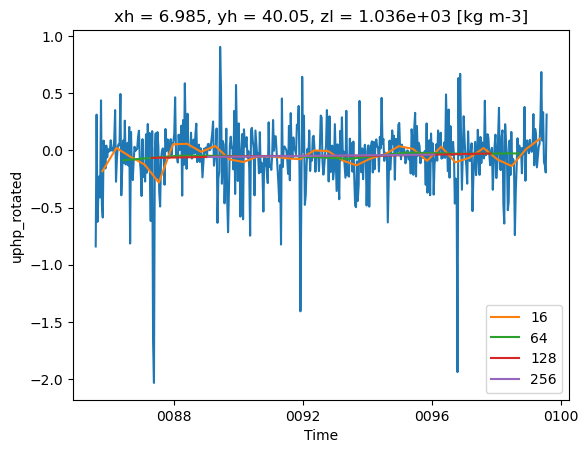

In [82]:
exp = 'DG'
scale = '50'

eval_sys.eval_datatree.ml_dataset[exp][scale].uphp_rotated.isel(zl=1
                                    ).sel(xh=7,yh=40, method='nearest').plot()
for coarsen_scale in eval_sys.coarsen_times: 
    eval_sys.eval_datatree.ml_dataset[exp][scale][coarsen_scale].uphp_rotated.isel(zl=1
                                    ).sel(xh=7,yh=40, method='nearest').plot(label=coarsen_scale)

plt.legend()

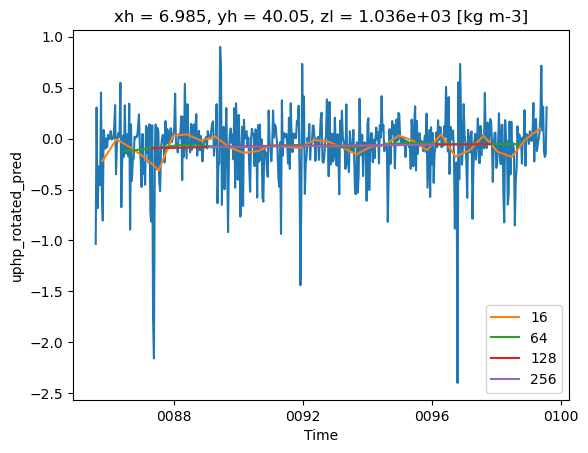

In [83]:
exp = 'DG'
scale = '50'

eval_sys.eval_datatree.ml_dataset[exp][scale].uphp_rotated_pred.isel(zl=1
                                    ).sel(xh=7,yh=40, method='nearest').plot()
for coarsen_scale in eval_sys.coarsen_times: 
    eval_sys.eval_datatree.ml_dataset[exp][scale][coarsen_scale].uphp_rotated_pred.isel(zl=1
                                    ).sel(xh=7,yh=40, method='nearest').plot(label=coarsen_scale)

plt.legend()

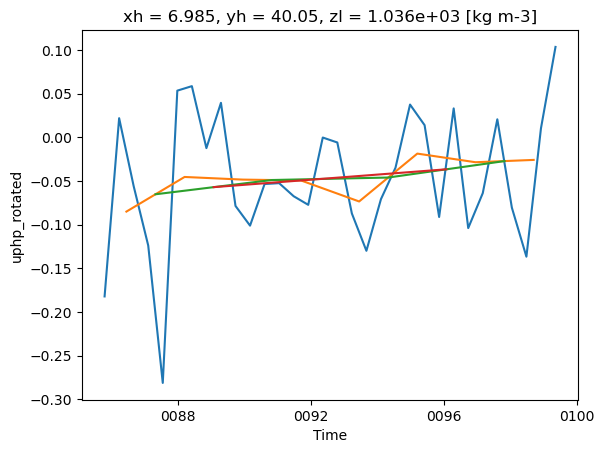

In [29]:

eval_sys.eval_datatree.ml_dataset[exp][scale].uphp_rotated.isel(zl=1
                                    ).sel(xh=7,yh=40, method='nearest').coarsen(Time=16, boundary='trim').mean().plot()
eval_sys.eval_datatree.ml_dataset[exp][scale].uphp_rotated.isel(zl=1
                                    ).sel(xh=7,yh=40, method='nearest').coarsen(Time=64, boundary='trim').mean().plot()
eval_sys.eval_datatree.ml_dataset[exp][scale].uphp_rotated.isel(zl=1
                                    ).sel(xh=7,yh=40, method='nearest').coarsen(Time=128, boundary='trim').mean().plot()
eval_sys.eval_datatree.ml_dataset[exp][scale].uphp_rotated.isel(zl=1
                                    ).sel(xh=7,yh=40, method='nearest').coarsen(Time=256, boundary='trim').mean().plot()


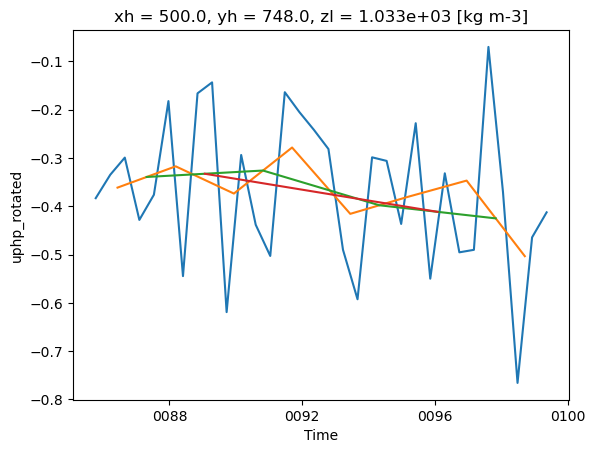

In [30]:
exp = 'P2L'
scale = '50'

eval_sys.eval_datatree.ml_dataset[exp][scale].uphp_rotated.isel(zl=1
                                    ).sel(xh=500,yh=750, method='nearest').coarsen(Time=16, boundary='trim').mean().plot()
eval_sys.eval_datatree.ml_dataset[exp][scale].uphp_rotated.isel(zl=1
                                    ).sel(xh=500,yh=750, method='nearest').coarsen(Time=64, boundary='trim').mean().plot()
eval_sys.eval_datatree.ml_dataset[exp][scale].uphp_rotated.isel(zl=1
                                    ).sel(xh=500,yh=750, method='nearest').coarsen(Time=128, boundary='trim').mean().plot()
eval_sys.eval_datatree.ml_dataset[exp][scale].uphp_rotated.isel(zl=1
                                    ).sel(xh=500,yh=750, method='nearest').coarsen(Time=256, boundary='trim').mean().plot()


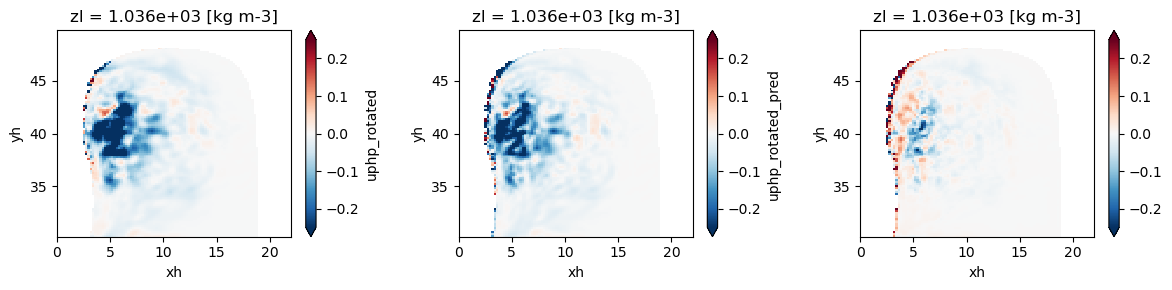

In [7]:
plt.figure(figsize=(12,3))

vmin = -.25
ds = eval_sys.eval_datatree.ml_dataset['DG']['100']

plt.subplot(131)
ds.uphp_rotated.isel(Time=slice(0,100), zl=1).mean('Time').plot(vmin=vmin)

plt.subplot(132)
ds.uphp_rotated_pred.isel(Time=slice(0,100), zl=1).mean('Time').plot(vmin=vmin)

plt.subplot(133)
(ds.uphp_rotated - ds.uphp_rotated_pred).isel(Time=slice(0,100), zl=1).mean('Time').plot(vmin=vmin)

plt.tight_layout()

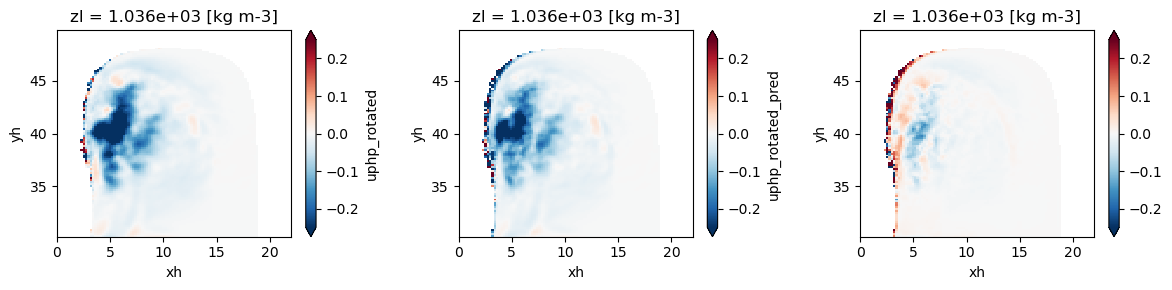

In [8]:
plt.figure(figsize=(12,3))

vmin = -.25
ds = eval_sys.eval_datatree.ml_dataset['DG']['100']

plt.subplot(131)
ds.uphp_rotated.isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.subplot(132)
ds.uphp_rotated_pred.isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.subplot(133)
(ds.uphp_rotated - ds.uphp_rotated_pred).isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.tight_layout()

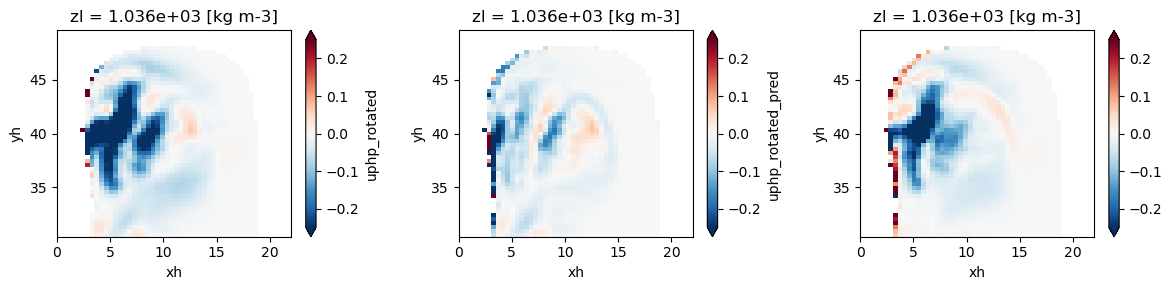

In [10]:
plt.figure(figsize=(12,3))

vmin = -.25
ds = eval_sys.eval_datatree.ml_dataset['DG']['200']

plt.subplot(131)
ds.uphp_rotated.isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.subplot(132)
ds.uphp_rotated_pred.isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.subplot(133)
(ds.uphp_rotated - ds.uphp_rotated_pred).isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.tight_layout()

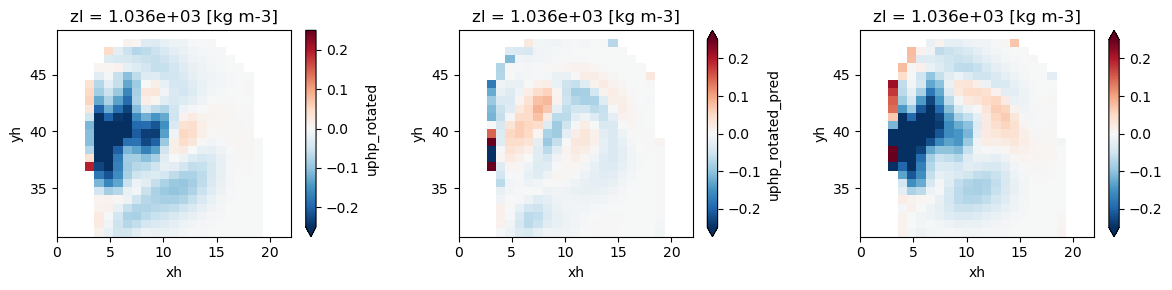

In [11]:
plt.figure(figsize=(12,3))

vmin = -.25
ds = eval_sys.eval_datatree.ml_dataset['DG']['400']

plt.subplot(131)
ds.uphp_rotated.isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.subplot(132)
ds.uphp_rotated_pred.isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.subplot(133)
(ds.uphp_rotated - ds.uphp_rotated_pred).isel(Time=slice(0,500), zl=1).mean('Time').plot(vmin=vmin)

plt.tight_layout()

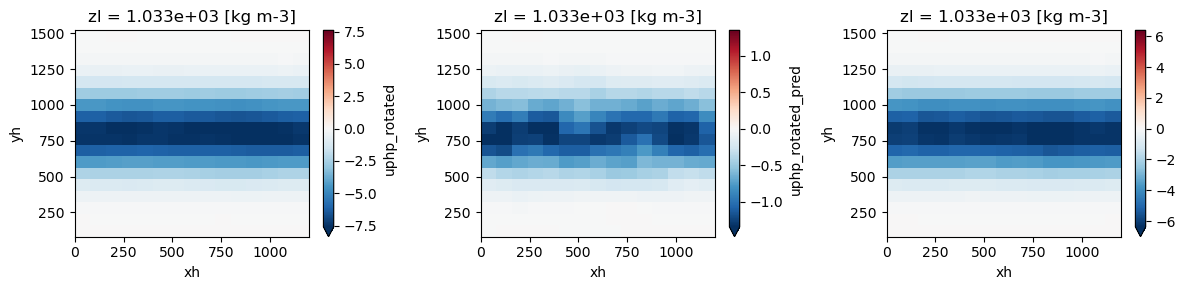

In [24]:
plt.figure(figsize=(12,3))

ds = eval_sys.eval_datatree.ml_dataset['P2L']['400']

plt.subplot(131)
ds.uphp_rotated.isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.subplot(132)
ds.uphp_rotated_pred.isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.subplot(133)
(ds.uphp_rotated - ds.uphp_rotated_pred).isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.tight_layout()

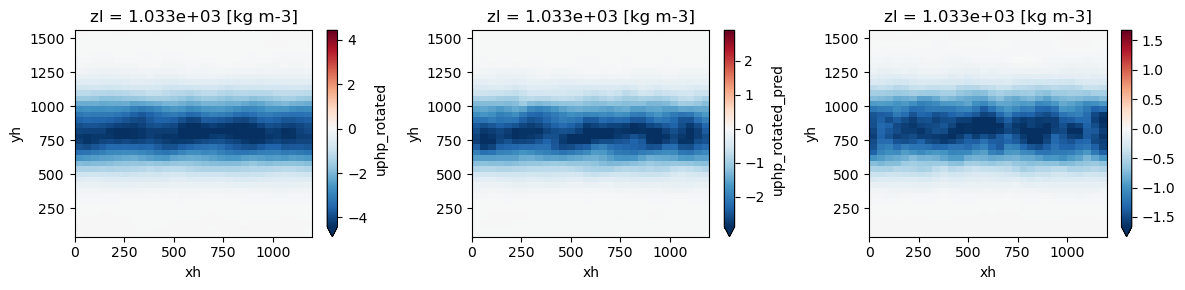

In [25]:
plt.figure(figsize=(12,3))

ds = eval_sys.eval_datatree.ml_dataset['P2L']['200']

plt.subplot(131)
ds.uphp_rotated.isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.subplot(132)
ds.uphp_rotated_pred.isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.subplot(133)
(ds.uphp_rotated - ds.uphp_rotated_pred).isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.tight_layout()

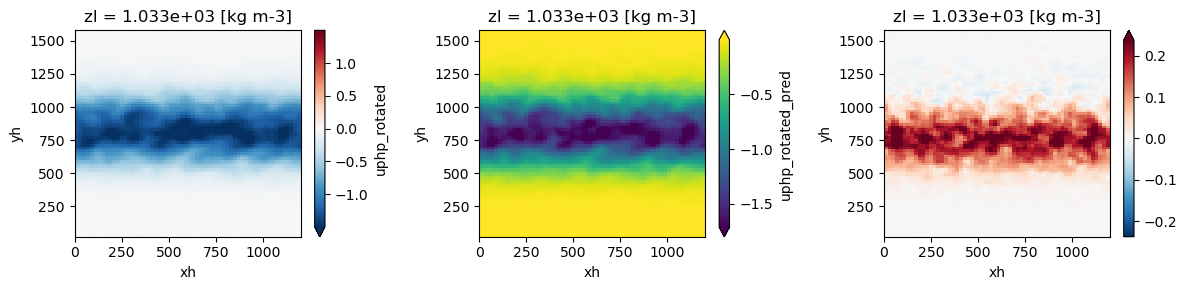

In [26]:
plt.figure(figsize=(12,3))

ds = eval_sys.eval_datatree.ml_dataset['P2L']['100']

plt.subplot(131)
ds.uphp_rotated.isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.subplot(132)
ds.uphp_rotated_pred.isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.subplot(133)
(ds.uphp_rotated - ds.uphp_rotated_pred).isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.tight_layout()

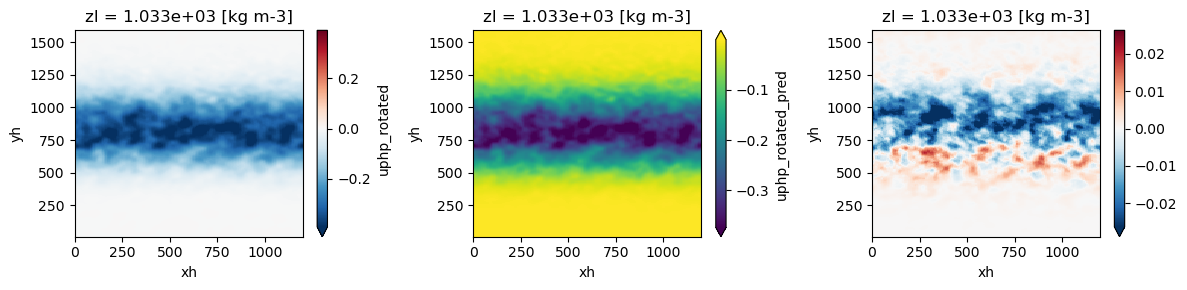

In [27]:
plt.figure(figsize=(12,3))

ds = eval_sys.eval_datatree.ml_dataset['P2L']['50']

plt.subplot(131)
ds.uphp_rotated.isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.subplot(132)
ds.uphp_rotated_pred.isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.subplot(133)
(ds.uphp_rotated - ds.uphp_rotated_pred).isel(Time=slice(0,500), zl=1).mean('Time').plot(robust=True)

plt.tight_layout()